In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import glob

from collections import deque
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D, AveragePooling2D, Input, Concatenate, LeakyReLU, Add, Multiply
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model, Sequence
from tensorflow.keras.callbacks import EarlyStopping


import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import gc
from tensorflow.keras import backend as K

# Utils

In [ ]:
# plot training history function
def plot_training_history(history):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([0, 3])
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!unzip /content/drive/MyDrive/Thesis/RWF-2000.zip -d /content

DIR_PATH = "./RWF-2000"
TRAIN_DIR = os.path.join(DIR_PATH, "train")
TEST_DIR = os.path.join(DIR_PATH, "val")

Mounted at /content/drive
Archive:  /content/drive/MyDrive/Thesis/RWF-2000.zip
   creating: /content/RWF-2000/
   creating: /content/RWF-2000/train/
   creating: /content/RWF-2000/train/Fight/
  inflating: /content/RWF-2000/train/Fight/train_Fight (1).avi  
  inflating: /content/RWF-2000/train/Fight/train_Fight (10).avi  
  inflating: /content/RWF-2000/train/Fight/train_Fight (100).avi  
  inflating: /content/RWF-2000/train/Fight/train_Fight (101).avi  
  inflating: /content/RWF-2000/train/Fight/train_Fight (102).avi  
  inflating: /content/RWF-2000/train/Fight/train_Fight (103).avi  
  inflating: /content/RWF-2000/train/Fight/train_Fight (104).avi  
  inflating: /content/RWF-2000/train/Fight/train_Fight (105).avi  
  inflating: /content/RWF-2000/train/Fight/train_Fight (106).avi  
  inflating: /content/RWF-2000/train/Fight/train_Fight (107).avi  
  inflating: /content/RWF-2000/train/Fight/train_Fight (108).avi  
  inflating: /content/RWF-2000/train/Fight/train_Fight (109).avi  
  infl

In [ ]:
CLASS_NAMES = os.listdir(TRAIN_DIR)
SEED = 1337
BATCH_SIZE = 10

ORIGINAL_FRAMES_PER_VIDEO = 150
FRAMES_PER_VIDEO  = 51
VIDEO_WIDTH, VIDEO_HEIGHT = 100, 100
N_CHANNELS = 3

## Load Data

In [ ]:
# get list of labels and video path
def get_labels_and_video_paths(data_dir):
    labels = []
    video_paths = []
    for label in CLASS_NAMES:
        label_dir = os.path.join(data_dir, label)
        for video in os.listdir(label_dir):
            video_paths.append(os.path.join(label_dir, video))
            labels.append(label)
    return labels, video_paths

In [ ]:
def load_videos(video_IDs: list, video_labels: dict, video_frames: int = FRAMES_PER_VIDEO, video_width: int = VIDEO_WIDTH, video_height: int = VIDEO_HEIGHT,
                video_channels: int = N_CHANNELS, dtype = np.float32, normalize: bool = False) -> tuple:
    videos = np.empty((len(video_IDs), video_frames, video_height, video_width, video_channels), dtype=dtype)
    labels = np.empty((len(video_IDs),), dtype=np.int8)

    # Indexes of frames to be kept to comply with video_frames
    frames_idx = set(np.round(np.linspace(0, ORIGINAL_FRAMES_PER_VIDEO - 1, video_frames)).astype(int))

    for i, video_ID in enumerate(video_IDs):
        cap = cv2.VideoCapture(video_ID)
        frames = []
        index = 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            if index in frames_idx:
                frame = cv2.resize(frame, (video_width, video_height)).astype(dtype)
                if normalize:
                    frame /= 255.0
                frames.append(frame)
            index += 1
        cap.release()

        videos[i,] = np.array(frames)
        labels[i] = video_labels[video_ID]

    return videos, labels

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, video_IDs: list, video_labels: dict, batch_size: int, video_width: int = VIDEO_WIDTH, video_height: int = VIDEO_HEIGHT,
                video_frames: int = FRAMES_PER_VIDEO, video_channels: int = N_CHANNELS, dtype = np.float32, normalize: bool = False, shuffle: bool = True):
        self.video_IDs = video_IDs
        self.video_labels = video_labels
        self.batch_size = batch_size
        self.video_width = video_width
        self.video_height = video_height
        self.video_frames = video_frames
        self.video_channels = video_channels
        self.dtype = dtype
        self.normalize = normalize
        self.shuffle = shuffle

    def __len__(self):
        return len(self.video_IDs) // self.batch_size

    def __getitem__(self, idx):
        bacth_IDs = self.video_IDs[idx*self.batch_size:(idx+1)*self.batch_size]

        return load_videos(bacth_IDs, self.video_labels, self.video_frames, self.video_width, self.video_height, self.video_channels, self.dtype, self.normalize)

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle:
            np.random.shuffle(self.video_IDs)
        # Clear memory after epochs
        gc.collect()
        #K.clear_session()

In [ ]:
train_video_IDs = glob.glob(f"{DIR_PATH}/train/*/*")
train_video_labels = {video: 0 if 'NonFight' in video else 1 for video in train_video_IDs}
test_video_IDs = glob.glob(f"{DIR_PATH}/val/*/*")
test_video_labels = {video: 0 if 'NonFight' in video else 1 for video in test_video_IDs}

train_generator = DataGenerator(train_video_IDs, train_video_labels, batch_size=10)
test_generator = DataGenerator(test_video_IDs, test_video_labels, batch_size=10)

# Training Model

In [ ]:
def tf_frame_diff(video):
    return video[1:] - video[:-1]

In [ ]:
# Define a custom motion blur layer
class MotionBlur(layers.Layer):
    def __init__(self, kernel_size=3, **kwargs):
        super(MotionBlur, self).__init__(**kwargs)
        self.kernel_size = kernel_size

    def build(self, input_shape):
        self.kernel = tf.constant([[1.0 / self.kernel_size] * self.kernel_size], dtype=tf.float32)
        self.kernel = tf.expand_dims(self.kernel, axis=-1)
        self.kernel = tf.expand_dims(self.kernel, axis=-1)
        self.kernel = tf.tile(self.kernel, [1, 1, input_shape[-1], 1])

    def call(self, inputs):
        return tf.nn.depthwise_conv2d(inputs, self.kernel, strides=[1, 1, 1, 1], padding='SAME')

    def compute_output_shape(self, input_shape):
        return input_shape

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Define a custom motion blur layer (applied across frames)
class MotionBlur(layers.Layer):
    def __init__(self, kernel_size=3, **kwargs):
        super(MotionBlur, self).__init__(**kwargs)
        self.kernel_size = kernel_size

    def build(self, input_shape):
        self.kernel = tf.constant([[1.0 / self.kernel_size] * self.kernel_size], dtype=tf.float32)
        self.kernel = tf.expand_dims(self.kernel, axis=-1)
        self.kernel = tf.expand_dims(self.kernel, axis=-1)
        self.kernel = tf.tile(self.kernel, [1, 1, input_shape[-1], 1])

    def call(self, inputs):
        return tf.nn.depthwise_conv2d(inputs, self.kernel, strides=[1, 1, 1, 1], padding='SAME')

    def compute_output_shape(self, input_shape):
        return input_shape

# Input layer for video sequences
inputs = layers.Input(shape=(FRAMES_PER_VIDEO, VIDEO_HEIGHT, VIDEO_WIDTH, 3))

# Apply Histogram Equalization
x = layers.Lambda(lambda video: tf.map_fn(lambda frame: tf.image.per_image_standardization(frame), video))(inputs)

# Add Gaussian Noise
x = layers.GaussianNoise(0.1)(x)

# Add Motion Blur (applied across frames)
x = layers.TimeDistributed(MotionBlur(kernel_size=5))(x)

# Compute Frame Differences
inputs_diff = layers.Lambda(lambda video: tf.map_fn(tf_frame_diff, video))(x)

# Conv3D block 1
x = layers.Conv3D(
    filters=8,
    kernel_size=(3, 3, 3),
    padding='same',
    activation='relu',
    kernel_regularizer=tf.keras.regularizers.l2(0.01)
)(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling3D(pool_size=(1, 2, 2), padding='same')(x)
x = layers.Dropout(0.3)(x)

# Conv3D block 2
x = layers.Conv3D(
    filters=16,
    kernel_size=(3, 3, 3),
    padding='same',
    activation='relu',
    kernel_regularizer=tf.keras.regularizers.l2(0.01)
)(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling3D(pool_size=(2, 2, 2), padding='same')(x)
x = layers.Dropout(0.3)(x)

# Conv3D block 3
x = layers.Conv3D(
    filters=32,
    kernel_size=(3, 3, 3),
    padding='same',
    activation='relu',
    kernel_regularizer=tf.keras.regularizers.l2(0.01)
)(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling3D(pool_size=(2, 2, 2), padding='same')(x)


# Global Average Pooling
x = layers.GlobalAveragePooling3D()(x)

# Fully Connected Dense Layers
x = layers.Dense(units=128, activation='relu')(x)
x = layers.Dense(units=16, activation='relu')(x)

# Output layer for binary classification
outputs = layers.Dense(units=1, activation='sigmoid')(x)

# Define and compile the model
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 51, 100, 100, 3)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 51, 100, 100, 3)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gaussian_noise (GaussianNoise)       │ (None, 51, 100, 100, 3)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 51, 100, 100, 3)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d (Conv3D)                      │ (None, 51, 100, 100, 8)     │             656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 51, 100, 100, 8)     │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 51, 50, 50, 8)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 51, 50, 50, 8)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_1 (Conv3D)                    │ (None, 51, 50, 50, 16)      │           3,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 51, 50, 50, 16)      │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 26, 25, 25, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 26, 25, 25, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_2 (Conv3D)                    │ (None, 26, 25, 25, 32)      │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 26, 25, 25, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_2 (MaxPooling3D)       │ (None, 13, 13, 13, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling3d             │ (None, 32)                  │               0 │
│ (GlobalAveragePooling3D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │           2,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 24,513 (95.75 KB)

 Trainable params: 24,401 (95.32 KB)

 Non-trainable params: 112 (448.00 B)

In [ ]:
# Add callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-6)

In [ ]:
EPOCH = 30


# train the model
train_hist = model.fit(train_generator,
                            validation_data = test_generator,
                            epochs = EPOCH,
                            callbacks=[lr_scheduler])

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


160/160 ━━━━━━━━━━━━━━━━━━━━ 600s 4s/step - accuracy: 0.4490 - loss: 1.0102 - val_accuracy: 0.5500 - val_loss: 0.7965 - learning_rate: 0.0010
Epoch 2/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 601s 3s/step - accuracy: 0.5051 - loss: 0.7788 - val_accuracy: 0.4650 - val_loss: 0.7453 - learning_rate: 0.0010
Epoch 3/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 620s 3s/step - accuracy: 0.6404 - loss: 0.6699 - val_accuracy: 0.6150 - val_loss: 0.6497 - learning_rate: 0.0010
Epoch 4/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 579s 4s/step - accuracy: 0.7046 - loss: 0.6073 - val_accuracy: 0.7550 - val_loss: 0.5825 - learning_rate: 0.0010
Epoch 5/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 587s 4s/step - accuracy: 0.6847 - loss: 0.6193 - val_accuracy: 0.7550 - val_loss: 0.5358 - learning_rate: 0.0010
Epoch 6/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 587s 4s/step - accuracy: 0.6975 - loss: 0.6124 - val_accuracy: 0.5000 - val_loss: 0.6868 - learning_rate: 0.0010
Epoch 7/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 617s 4s/step - accuracy: 0.7060 - loss: 0.5961 - val_

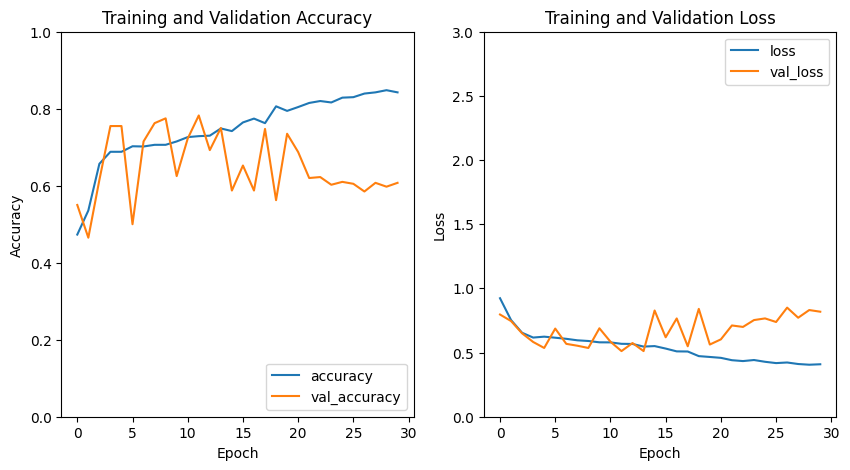

In [ ]:
plot_training_history(train_hist)


In [ ]:
max_val_acc = max(train_hist.history['val_accuracy'])

print(f"max val accuracy: {max_val_acc:.2f}")

max val accuracy: 0.78
